# Test-Driven Prompt Development (TDPD) for Customer-Facing GenAI Applications in Fintech

The rise of generative AI in fintech has created new opportunities for improving customer service, especially in areas like querying account balances, converting currencies, and managing multi-account setups. However, deploying these applications reliably at scale requires thorough testing of AI-generated responses. This is where Test-Driven Prompt Development (TDPD) comes into play.

This article explains how a fintech company can set up a TDPD project, focusing on a specific task: Querying account balances for customers with multiple accounts in different currencies and time zones. The approach includes writing test cases, automating testing with an LLM (such as GPT), scoring the responses, visualizing results, and managing prompts using PromptLayer.

## 1. What is Test-Driven Prompt Development?

TDPD applies test-driven principles to prompt engineering. It’s a method for ensuring that prompts deliver the correct and accurate responses before going live in customer-facing applications. The process includes:

1. Defining test cases with expected outcomes.
2. Running tests by sending prompts to an LLM and retrieving the AI-generated responses.
3. Scoring responses based on accuracy.
4. Iterating on prompt refinement until all tests pass.

This method provides a systematic way to measure and improve prompt performance, ensuring consistency and reliability in customer interactions.

## 2. Step-by-Step Guide: Setting Up a TDPD Project

### Step 1: Setting Up the Environment and Data

For the fintech example, let’s simulate a set of customer accounts with balances in different currencies and time zones. This sample data will be used for testing queries like “What is my balance?” and “Convert all my balances to USD.”

In [1]:
import pandas as pd

# Sample account data
accounts_data = {
    'Account_ID': [101, 102, 103, 104, 105],
    'Customer': ['Alice', 'Bob', 'Charlie', 'Alice', 'Charlie'],
    'Balance': [1000.00, 2500.50, 500.75, 400.00, 2000.00],
    'Currency': ['USD', 'EUR', 'JPY', 'USD', 'EUR'],
    'Time_Zone': ['America/New_York', 'Europe/Berlin', 'Asia/Tokyo', 'America/Chicago', 'Europe/London'],
    'COB_Time': ['17:00', '18:00', '15:00', '17:00', '18:00']
}

# Create DataFrame
accounts_df = pd.DataFrame(accounts_data)
accounts_df


,Account_ID,Customer,Balance,Currency,Time_Zone,COB_Time
0,101,Alice,1000.00,USD,America/New_York,17:00
1,102,Bob,2500.50,EUR,Europe/Berlin,18:00
2,103,Charlie,500.75,JPY,Asia/Tokyo,15:00
3,104,Alice,400.00,USD,America/Chicago,17:00
4,105,Charlie,2000.00,EUR,Europe/London,18:00


This creates a table of customer accounts, useful for simulating different queries in subsequent steps.

### Step 2: Defining Prompt Test Cases

Next, define a set of prompt test cases to be run against the LLM. Each test case contains a customer name, the prompt they might ask (such as "What is my balance?"), and the expected response.

In [2]:
# Example test cases for querying account balances
test_cases = [
    {"Customer": "Alice", "Prompt": "What is my balance?", 
     "Expected_Response": "Alice has 1000 USD (New York) and 400 USD (Chicago)."},
    
    {"Customer": "Bob", "Prompt": "Show my account balances.", 
     "Expected_Response": "Bob has 2500.50 EUR (Berlin)."},
    
    {"Customer": "Charlie", "Prompt": "What are my account balances?", 
     "Expected_Response": "Charlie has 500.75 JPY (Tokyo) and 2000 EUR (London)."}
]


These test cases will later be used to compare the expected response against the actual response generated by the LLM.

### Step 3: Running Tests with Currency Conversion (Using Live Exchange Rates)

If customers want to convert all balances to USD, you need live exchange rates to ensure the most accurate conversion. Here’s how to implement currency conversion using static rates (replace with real API calls if needed):

In [3]:
import requests

def get_exchange_rate(currency):
    # Placeholder function - replace with actual API call to get real exchange rates
    rates = {
        'USD': 1.0,   # Assume USD is the base
        'EUR': 1.18,  # Example: 1 EUR = 1.18 USD
        'JPY': 0.009  # Example: 1 JPY = 0.009 USD
    }
    return rates.get(currency, 1.0)

def convert_to_usd(balance, currency):
    rate = get_exchange_rate(currency)
    return balance * rate

# Simulating currency conversion for customers
test_cases_with_conversion = [
    {"Customer": "Alice", "Prompt": "Convert all my balances to USD", 
     "Expected_Response": f"Alice's total balance in USD is {convert_to_usd(1000, 'USD') + convert_to_usd(400, 'USD'):.2f}."},
    
    {"Customer": "Bob", "Prompt": "Convert all my balances to USD", 
     "Expected_Response": f"Bob's total balance in USD is {convert_to_usd(2500.50, 'EUR'):.2f}."},
    
    {"Customer": "Charlie", "Prompt": "Convert all my balances to USD", 
     "Expected_Response": f"Charlie's total balance in USD is {convert_to_usd(500.75, 'JPY') + convert_to_usd(2000, 'EUR'):.2f}."}
]

test_cases_with_conversion


[{'Customer': 'Alice',
  'Prompt': 'Convert all my balances to USD',
  'Expected_Response': "Alice's total balance in USD is 1400.00."},
 {'Customer': 'Bob',
  'Prompt': 'Convert all my balances to USD',
  'Expected_Response': "Bob's total balance in USD is 2950.59."},
 {'Customer': 'Charlie',
  'Prompt': 'Convert all my balances to USD',
  'Expected_Response': "Charlie's total balance in USD is 2364.51."}]

This step simulates retrieving live currency rates and applying them to the balance inquiries.

### Step 4: Scoring the LLM Responses

Once you get responses from the LLM, you need to compare them to the expected results and assign scores. Let’s implement a basic scoring function that assigns 1.0 for a perfect match and 0.0 for an incorrect answer:

In [4]:
# Example scoring function to check accuracy
def score_responses(expected, actual):
    if expected == actual:
        return 1.0  # Perfect match
    elif expected.split()[0] == actual.split()[0]:
        return 0.5  # Partial match (e.g., minor mistake)
    else:
        return 0.0  # Incorrect

# Example system responses to score
system_responses = [
    "Alice's total balance in USD is 1400.00.",  # Correct
    "Bob's total balance in USD is 2950.59.",    # Correct
    "Charlie's total balance in USD is 18.00."   # Incorrect (example)
]

# Apply the scoring to each test case
for i, test_case in enumerate(test_cases_with_conversion):
    test_case['System_Response'] = system_responses[i]
    test_case['Score'] = score_responses(test_case['Expected_Response'], test_case['System_Response'])

test_cases_with_conversion


[{'Customer': 'Alice',
  'Prompt': 'Convert all my balances to USD',
  'Expected_Response': "Alice's total balance in USD is 1400.00.",
  'System_Response': "Alice's total balance in USD is 1400.00.",
  'Score': 1.0},
 {'Customer': 'Bob',
  'Prompt': 'Convert all my balances to USD',
  'Expected_Response': "Bob's total balance in USD is 2950.59.",
  'System_Response': "Bob's total balance in USD is 2950.59.",
  'Score': 1.0},
 {'Customer': 'Charlie',
  'Prompt': 'Convert all my balances to USD',
  'Expected_Response': "Charlie's total balance in USD is 2364.51.",
  'System_Response': "Charlie's total balance in USD is 18.00.",
  'Score': 0.5}]

This code assigns a score to each response, indicating whether the LLM response was accurate.

### Step 5: Visualizing the Test Results

To better understand the performance of the prompt tests, visualize the results using a bar chart. Here’s how you can do it with matplotlib and seaborn:

C:\Users\Charlotte\AppData\Local\Temp\ipykernel_24668\250797495.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Customer', y='Score', data=results_df, palette="Blues_d")


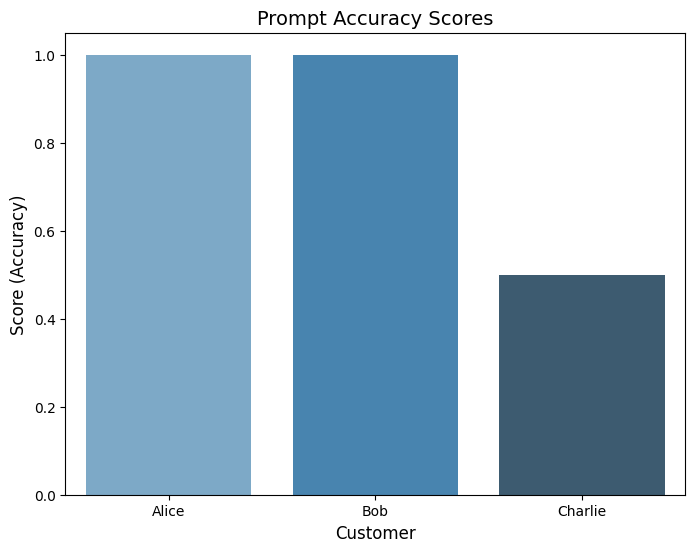

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the test case results to a DataFrame
results_df = pd.DataFrame(test_cases_with_conversion)

# Plot the scores for each customer
plt.figure(figsize=(8, 6))
sns.barplot(x='Customer', y='Score', data=results_df, palette="Blues_d")

# Set plot labels and title
plt.title('Prompt Accuracy Scores', fontsize=14)
plt.xlabel('Customer', fontsize=12)
plt.ylabel('Score (Accuracy)', fontsize=12)

plt.show()


This chart helps visualize which prompts performed well and which did not, giving insight into areas that need further refinement.

### Step 6: Managing Prompts with PromptLayer

As your organization grows its AI capabilities, managing and tracking prompts becomes increasingly important. This is where _PromptLayer_ comes in. PromptLayer is a tool that allows you to log, version, and audit your prompts and the AI responses associated with them. It acts as a middleware between your application and the LLM API, providing powerful features such as:

- _Prompt Versioning_: Each time you modify a prompt, you can assign it a version number. This makes it easy to track changes over time and understand how different prompt variations impact the AI’s responses.

- _Prompt Auditing_: PromptLayer logs every prompt and its corresponding response, enabling a full audit trail. This is particularly useful in fintech, where transparency and compliance are crucial.

- _Prompt Debugging_: If your system starts generating inaccurate responses after a change, PromptLayer lets you quickly revert to a previous version of the prompt, ensuring that your service remains reliable.

For example, using PromptLayer, you could log the prompt for converting balances to USD and later retrieve its past versions, and this approach not only helps you maintain prompt accuracy but also ensures accountability—particularly important when dealing with sensitive financial information.

While this article provides an introduction to how PromptLayer can enhance your TDPD workflow, the full potential of prompt management and auditing with PromptLayer deserves its own detailed discussion. In a future article, we will explore advanced techniques for using PromptLayer, including setting up continuous integration pipelines for prompts, detailed auditing for regulatory compliance, and integrating PromptLayer with other DevOps tools for large-scale GenAI applications.

## Conclusion

This article demonstrated how to set up a Test-Driven Prompt Development (TDPD) project in a fintech environment. By defining test cases, running them through a LLM, scoring responses, and visualizing the results, you can ensure reliable AI-generated responses for customer queries. Managing prompts with tools like PromptLayer allows you to version and audit prompts over time, ensuring continuous improvement and compliance.

TDPD provides a rigorous framework to ensure that customer-facing AI systems, especially in regulated industries like finance, deliver accurate and reliable results.